# Clustering game data with Spark MLlib BY : Yazan Ho

In [1]:
import pandas as pd
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array

In [2]:
import findspark
findspark.init()
findspark.find()

'C:\\Program Files\\spark\\spark-3.2.1-bin-hadoop3.2'

## Step 1: Attribute Selection

### Import Data

First read the contents of the file ad-clicks.csv. The following commands read in the CSV file in a table format and removes any extra whitespaces. So, if the CSV contained ' userid  ' it becomes 'userid'. 

In [3]:
adclicksDF = pd.read_csv('C:/Users/ASUS ROG/Desktop/Big Data course/Capston Final Project/big_data_capstone_datasets_and_scripts/big_data_capstone_datasets_and_scripts/flamingo-data/ad-clicks.csv')
adclicksDF = adclicksDF.rename(columns=lambda x: x.strip()) #remove whitespaces from headers

In [4]:
adclicksDF.head(5) # Display first 5 rows

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing


Next, add an extra column to the ad-clicks table and make it equal to 1. We do so to record the fact that each row is 1 ad-click. You will see how this will become useful when we sum up this column to find how many ads did a user click.

In [5]:
adclicksDF['adCount'] = 1

Let us display the first 5 lines of adclicksDF and see if a new column has been added:

In [6]:
adclicksDF.head(5)

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory,adCount
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics,1
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies,1
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers,1
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion,1
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing,1


Then read the contents of the file buy-clicks.csv. 
The following commands read in the CSV file in a table format and removes any extra whitespaces. 
So, if the CSV contained ' userid ' it becomes 'userid'.

In [7]:
buyClicksDF = pd.read_csv('C:/Users/ASUS ROG/Desktop/Big Data course/Capston Final Project/big_data_capstone_datasets_and_scripts/big_data_capstone_datasets_and_scripts/flamingo-data/buy-clicks.csv')
buyClicksDF = buyClicksDF.rename(columns=lambda x: x.strip()) #remove whitespaces from headers

In [8]:
buyClicksDF.head(5)

,timestamp,txId,userSessionId,team,userId,buyId,price
0,2016-05-26 15:36:54,6004,5820,9,1300,2,3.0
1,2016-05-26 15:36:54,6005,5775,35,868,4,10.0
2,2016-05-26 15:36:54,6006,5679,97,819,5,20.0
3,2016-05-26 16:36:54,6067,5665,18,121,2,3.0
4,2016-05-26 17:06:54,6093,5709,11,2222,5,20.0


In [9]:
buyClicksDF['buyCount'] = 1

### Feature Selection

For this exercise, we can choose from buyclicksDf,  the 'price' of each app that a user purchases as an attribute that captures user's purchasing behavior. The following command selects 'userid' and 'price' and drops all other columns that we do not want to use at this stage.
Then do the same thing for the rest of tables.

In [10]:
userPurchases = buyClicksDF[['userId','price']]
useradClicks = adclicksDF[['userId','adCount']]
userbuyClicks = buyClicksDF[['userId','buyCount']]

## Step 2: Training Data Set Creation

### Create the first aggregate feature for clustering

From each of these single ad-clicks per row, we can now generate total ad clicks per user. Let's pick a user with userid = 3. To find out how many ads this user has clicked overall, we have to find each row that contains userid = 3, and report the total number of such rows.

The following commands sum the total number of ads per user in the end, we want to get one row per user, if we are performing clustering over users.


In [11]:
totalAdClicks = useradClicks.groupby('userId').sum()
totalAdClicks = totalAdClicks.reset_index()

Let us display the first 5 lines of 'totalAdClicks'

In [12]:
totalAdClicks.head(n=5)

,userId,adCount
0,1,44
1,8,10
2,9,37
3,10,19
4,12,46


### Create the second aggregate feature for clustering

The following commands sum the total number of clicking on buy per user in the end, we want to get one row per user, if we are performing clustering over users.

In [13]:
totalBuyClicks = userbuyClicks.groupby('userId').sum()
totalBuyClicks = totalBuyClicks.reset_index()

Let us display the first 5 lines of 'totalBuyClicks'

In [14]:
totalBuyClicks.head(n=5)

,userId,buyCount
0,1,9
1,8,5
2,9,6
3,10,10
4,12,13


### Create the third aggregate feature for clustering

Similar to what we did for adclicks and buyclicks, here we find out how much money in total did each user spend on buying in-app purchases. As an example, let's pick a user with userId = 9. To find out the total money spent by this user, we have to find each row that contains userId = 9, and report the sum of the column'price' of each product they purchased.

The following commands sum the total money spent by each user.

In [15]:
totalRevenue = userPurchases.groupby('userId').sum()
totalRevenue = totalRevenue.reset_index()

In [16]:
totalRevenue.head(n=5)

,userId,price
0,1,21.0
1,8,53.0
2,9,80.0
3,10,11.0
4,12,215.0


### Merge the three tables

We have a table called totalRevenue, where each row contains total money a user (with that 'userId') has spent. We have a table called ads_per_user where each row contains total number of ads a user has clicked. We also have another table called totalBuyClicks where each row contains total number of buy clicking of a user in the game. We will use revenue_per_user, totalAdClicks.

Let us combine these three attributes (features) so that each row contains both attributes per user. Let's merge these three tables to get one single table we can use for K-Means clustering.

In [17]:
combainDF1 = totalAdClicks.merge(totalRevenue, on='userId')
combainDF = combainDF1.merge(totalBuyClicks, on='userId')

In [18]:
combainDF.head(n=5)

,userId,adCount,price,buyCount
0,1,44,21.0,9
1,8,10,53.0,5
2,9,37,80.0,6
3,10,19,11.0,10
4,12,46,215.0,13


### Create the final training dataset

Our training data set is almost ready. At this stage we can remove the 'userId' from each row, since 'userId' is a computer generated random number assigned to each user. It does not capture any behavioral aspect of a user. One way to drop the 'userId', is to select the other two columns.

In [19]:
trainingDF = combainDF[['adCount','buyCount','price']] # selecte column
trainingDF.head(n=5)

,adCount,buyCount,price
0,44,9,21.0
1,10,5,53.0
2,37,6,80.0
3,19,10,11.0
4,46,13,215.0


# Rename the columns:

In [20]:
trainingDF.columns = ['totalAdClicks', 'totalBuyClicks', 'Revenue'] # rename the columns
trainingDF.head(n=5)

,totalAdClicks,totalBuyClicks,Revenue
0,44,9,21.0
1,10,5,53.0
2,37,6,80.0
3,19,10,11.0
4,46,13,215.0


### Display the dimensions of the training dataset

Display the dimension of the training data set. To display the dimensions of the training_df, simply add `.shape` as a suffix and hit enter.

In [21]:
trainingDF.shape

(543, 3)

The following two commands convert the tables we created into a format that can be understood by the `KMeans.train` function.

line[0] refers to the first column. line[1] refers to the second column. If you have more than 2 columns in your training table, modify this command by adding line[2], line[3], line[4] ...

In [22]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
import findspark
findspark.init()
print('Spark',pyspark.__version__)
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Spark 3.1.2


In [23]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)
p_df = sqlContext.createDataFrame(trainingDF)
parsed_data = p_df.rdd.map(lambda line: array([line[0], line[1], line[2]])) #totalAdClicks, totalGameClicks, revenue

## Step 3: Train to Create Cluster Centers

### Train KMeans model

In [24]:
km_model = KMeans.train(parsed_data, 3, maxIterations=10, initializationMode="random")

In [25]:
headers = trainingDF.columns.values.tolist()
centers = [a.tolist() for a in km_model.centers]

### Display the centers of three clusters formed

In [26]:
df = pd.DataFrame(centers, columns=headers)
df.head()

,totalAdClicks,totalBuyClicks,Revenue
0,40.196429,9.625000,136.821429
1,25.355224,4.277612,14.767164
2,34.243421,6.388158,57.618421


array([<AxesSubplot:title={'center':'totalAdClicks'}>,
       <AxesSubplot:title={'center':'totalBuyClicks'}>,
       <AxesSubplot:title={'center':'Revenue'}>], dtype=object)

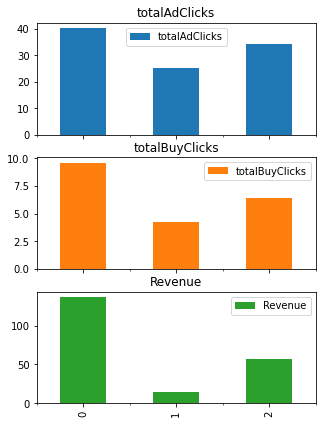

In [27]:
%matplotlib inline
df.plot(kind='bar',subplots=True, figsize=(5,7), use_index=True)

# Optional other way for Clustering

## Down thier 

### Thanks

In [28]:
p_df.count()

543

In [29]:
p_df.columns

['totalAdClicks', 'totalBuyClicks', 'Revenue']

In [30]:
p_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
totalAdClicks,543,29.373848987108655,15.216343215129635,1,67
totalBuyClicks,543,5.419889502762431,3.2447133253052716,1,16
Revenue,543,39.34990791896869,41.22173676708475,1.0,223.0


In [31]:
p_df = p_df.na.drop()

In [32]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [33]:
featuresUsed = ['totalAdClicks', 'totalBuyClicks', 'Revenue']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(p_df)

In [34]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [35]:
scaledData = scaledData.select("features")
scaledData.persist()

DataFrame[features: vector]

In [36]:
from pyspark.ml.clustering import KMeans

In [37]:
kmeans = KMeans(k=3, seed=1)  # 3 clusters here
model = kmeans.fit(scaledData.select('features'))

In [38]:
transformed = model.transform(scaledData)
transformed.show()  

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.96121326958165...|         1|
|[-1.2732263404682...|         0|
|[0.50118158515961...|         1|
|[-0.6817570319256...|         1|
|[1.09265089370223...|         2|
|[-0.8789134681065...|         0|
|[-0.9446322801668...|         0|
|[1.48696376606398...|         1|
|[-1.3389451525285...|         0|
|[-1.2732263404682...|         0|
|[-0.6160382198653...|         0|
|[0.30402514897873...|         2|
|[-0.0245689113227...|         0|
|[1.09265089370223...|         1|
|[0.56690039721990...|         1|
|[0.23830633691844...|         1|
|[-1.6018204007697...|         0|
|[0.69833802134048...|         1|
|[1.48696376606398...|         1|
|[-1.3389451525285...|         0|
+--------------------+----------+
only showing top 20 rows



In [39]:
centers = model.clusterCenters()
centers

[array([-0.87226487, -0.75059133, -0.45610086]),
 array([ 0.79264304,  0.50771051, -0.1042192 ]),
 array([0.75258212, 1.26480204, 2.22950481])]

# Remember To:

Download Apache Spark with winutils.exe
Download & Install Anaconda Distribution
Install Java using command:
### conda install openjdk
Install PySpark using command:
### conda install pyspark
Install FindSpark using command:
### conda install -c conda-forge findspark
Validate PySpark Installation from pyspark shell
PySpark in Jupyter notebook
Run PySpark from IDE

## Source can use:
https://changhsinlee.com/install-pyspark-windows-jupyter/
https://sparkbyexamples.com/pyspark/install-pyspark-in-anaconda-jupyter-notebook/